In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv('/content/drive/MyDrive/monthly_kilometers_traveled.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [39]:
df.head()

,Kilometers
Date,
1962-01-01,58.9
1962-02-01,56.1
1962-03-01,64.0
1962-04-01,65.6
1962-05-01,72.7


<Axes: xlabel='Date'>

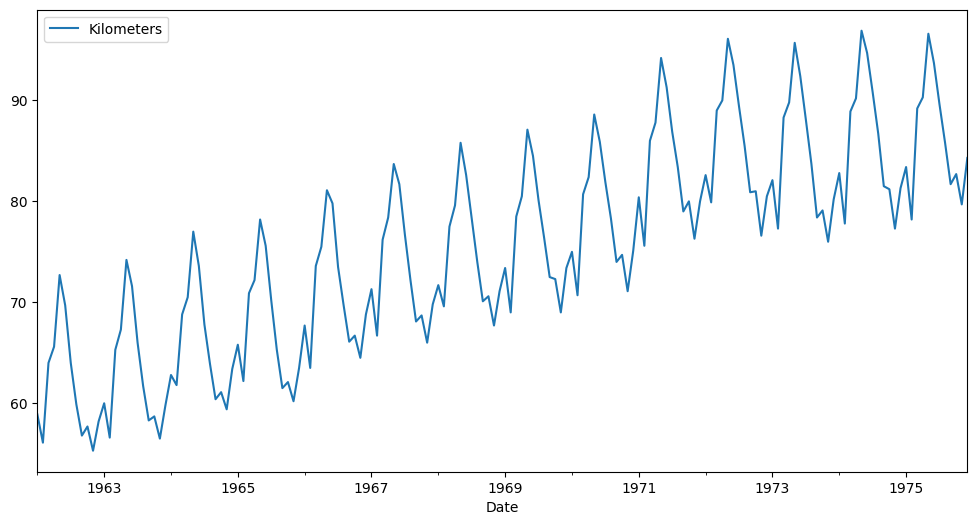

In [40]:
df.plot(figsize=(12,6))

In [43]:
len(df)

168

In [44]:
train = df.iloc[:156]
test = df.iloc[156:]

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [46]:
df.head(),df.tail()

(            Kilometers
 Date                  
 1962-01-01        58.9
 1962-02-01        56.1
 1962-03-01        64.0
 1962-04-01        65.6
 1962-05-01        72.7,
             Kilometers
 Date                  
 1975-08-01        85.8
 1975-09-01        81.7
 1975-10-01        82.7
 1975-11-01        79.7
 1975-12-01        84.3)

In [47]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [48]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [49]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [50]:
#Se define el generador
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [51]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [52]:
X.shape

(1, 3, 1)

In [53]:
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [55]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


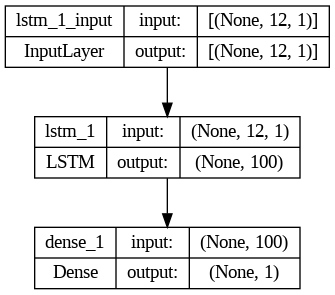

In [57]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [58]:
model.fit(generator,epochs=50)
# Guardando el modelo de la RNN (LSTM)
with open('modelLSTM1.pkl', 'wb') as modelSaved:
  pickle.dump(results, modelSaved)

Epoch 1/50
144/144 [==============================] - 3s 10ms/step - loss: 0.0429
Epoch 2/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0170
Epoch 3/50
144/144 [==============================] - 3s 17ms/step - loss: 0.0125
Epoch 4/50
144/144 [==============================] - 2s 17ms/step - loss: 0.0169
Epoch 5/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0078
Epoch 6/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 7/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 8/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0045
Epoch 9/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0040
Epoch 10/50
144/144 [==============================] - 3s 17ms/step - loss: 0.0067
Epoch 11/50
144/144 [==============================] - 2s 17ms/step - loss: 0.0036
Epoch 12/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0036
Epoch 13/50
1

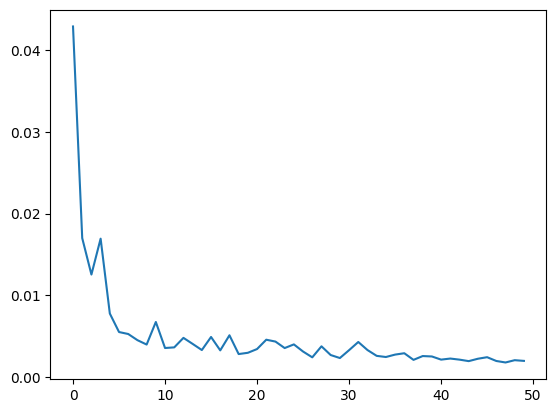

In [59]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [60]:
last_train_batch = scaled_train[-12:]

In [61]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch.shape

(1, 12, 1)

In [62]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 167ms/step


array([[0.6348962]], dtype=float32)

In [63]:
scaled_test[0]

array([0.67548077])

In [64]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # Se obtiene el valor de predicción para el primer batch
    current_pred = model.predict(current_batch)[0]

    # Se adjunta al array
    test_predictions.append(current_pred)

    # Se usa el valor de la predicción para actualizar el batch
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [65]:
test_predictions

[array([0.6348962], dtype=float32),
 array([0.59166884], dtype=float32),
 array([0.7799658], dtype=float32),
 array([0.83544457], dtype=float32),
 array([0.9310979], dtype=float32),
 array([0.90651727], dtype=float32),
 array([0.82990193], dtype=float32),
 array([0.74504703], dtype=float32),
 array([0.63846886], dtype=float32),
 array([0.6076023], dtype=float32),
 array([0.55144393], dtype=float32),
 array([0.58802724], dtype=float32)]

In [66]:
test.head()

,Kilometers
Date,
1975-01-01,83.4
1975-02-01,78.2
1975-03-01,89.2
1975-04-01,90.3
1975-05-01,96.6


In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
test['Predictions'] = true_predictions

<ipython-input-68-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

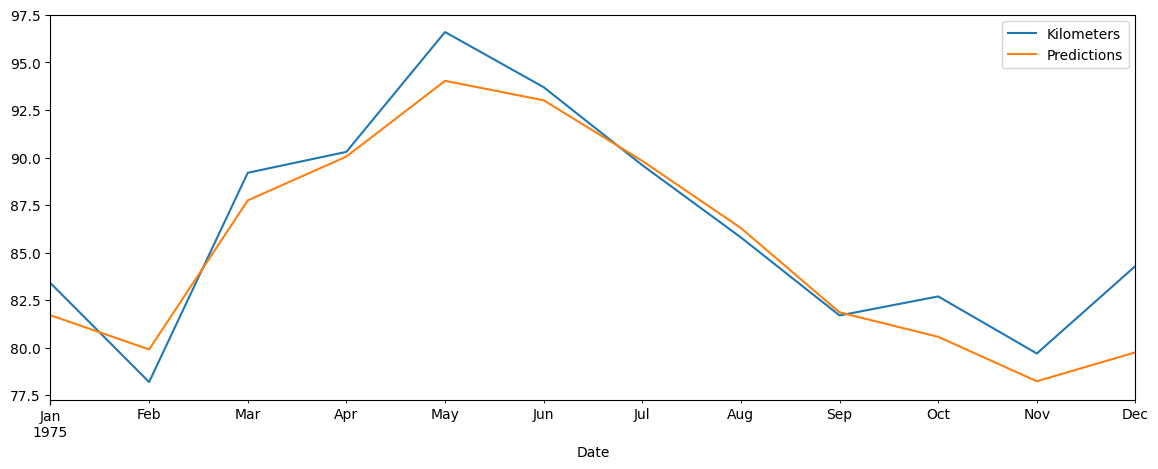

In [69]:
test.plot(figsize=(14,5))

In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Kilometers'],test['Predictions']))
print(rmse)

1.8835938338001048
